### Prepare Training and Testing Set

In [0]:
import numpy as np

np.random.seed(10)

# train, test split
data_split = [0.7, 0.3]

#read and divide data into test and train sets 
admit_data = np.genfromtxt('admission_predict.csv', delimiter=',')[1:, 1:]

idx = np.arange(admit_data.shape[0])
np.random.shuffle(idx)
admit_data = admit_data[idx]

assert sum(data_split) == 1
num_train = int(admit_data.shape[0] * data_split[0])
train_data = admit_data[:num_train]
test_data = admit_data[num_train:]

# Save training and testing data
with open("train_data.npy", 'wb') as f:
    np.save(f, train_data)
with open("test_data.npy", 'wb') as f:
    np.save(f, test_data)

### Model Class

In [0]:
import tensorflow as tf

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

class RegressionFFNN:
    def __init__(self, num_features, num_hidden, num_neurons, reg_constant):
        tf.reset_default_graph()
        tf.random.set_random_seed(10)
        
        # Input tensors
        self.x = tf.placeholder(tf.float32, [None, num_features])
        self.y_ = tf.placeholder(tf.float32, [None, 1])

        self.dropout_rate = tf.placeholder_with_default(0.0, shape=())
        
        # Hidden layers
        self.hidden_layers = []
        for i in range(num_hidden):
            input_dim = num_features if i == 0 else num_neurons
            input_tensor = self.x if i == 0 else self.hidden_layers[-1][-1]
            weight_init = tf.truncated_normal([input_dim, num_neurons], stddev=1.0 / np.sqrt(input_dim), dtype=tf.float32)
            
            hidden_weights = tf.Variable(weight_init, name=f"hidden_weights_{i}")
            hidden_biases = tf.Variable(tf.zeros([num_neurons]), dtype=tf.float32, name=f"hidden_biases_{i}")
            hidden = tf.nn.dropout(
                tf.nn.relu(tf.matmul(input_tensor, hidden_weights) + hidden_biases, name=f"hidden_{i}"), 
                rate=self.dropout_rate
            )
            
            self.hidden_layers.append((hidden_weights, hidden_biases, hidden))

        # Output layer
        weight_init = tf.truncated_normal([num_neurons, 1], stddev=1.0 / np.sqrt(num_neurons), dtype=tf.float32)
        self.output_weights = tf.Variable(weight_init, name='weights')
        self.output_biases = tf.Variable(tf.zeros([1]), dtype=tf.float32, name='biases')
        self.y = tf.matmul(self.hidden_layers[-1][-1], self.output_weights) + self.output_biases
        
        # Loss functions
        self.mse_loss = tf.reduce_mean(tf.square(self.y_ - self.y))
        self.reg_loss = tf.math.reduce_sum([tf.nn.l2_loss(m[0]) for m in self.hidden_layers]) \
                        + tf.nn.l2_loss(self.output_weights)
        self.loss = self.mse_loss + reg_constant * self.reg_loss
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    def train(self, epochs, learning_rate, batch_size, train_x, train_y, test_x, test_y, 
              dropout_rate=0.0, log_interval=100):
        # Create the gradient descent optimizer with the given learning rate.
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train_op = optimizer.minimize(self.loss)

        train_err = []
        test_err = []
        print(f"Training on {train_x.shape[0]} examples...")
        for i in range(epochs):
            for j in range(0, train_x.shape[0], batch_size):
                batch_x = train_x[j:j + batch_size]
                batch_y = train_y[j:j + batch_size]
                self.sess.run(train_op, feed_dict={self.x: batch_x, self.y_: batch_y, self.dropout_rate: dropout_rate})

            train_err.append(self.sess.run(self.mse_loss, feed_dict={self.x: train_x, self.y_: train_y}))
            test_err.append(self.sess.run(self.mse_loss, feed_dict={self.x: test_x, self.y_: test_y}))

            if i % log_interval == 0:
                print(f"Epoch {i}: train error {train_err[i]} test error {test_err[i]}")

        min_epoch = np.argmin(test_err)
        print(f"Done.\nEpoch with lowest test error: {min_epoch + 1} ({test_err[min_epoch]})")
        
        # for TensorBoard
#         writer = tf.summary.FileWriter("logs", self.sess.graph)
#         writer.close()
        
        return train_err, test_err
        
    def test(self, test_x):
        return self.sess.run(self.y, feed_dict = {self.x: test_x})

### Utility Functions

In [0]:
import pylab as plt

TEXT_COLOR = 'black'
plt.rc('xtick', color=TEXT_COLOR)
plt.rc('ytick', color=TEXT_COLOR)

def plot_curves(labelled_data, x_label, y_label, offset=0, figsize=(8,6)):
    plt.figure(figsize=figsize)
    for i, (label, data) in enumerate(labelled_data.items()):
        plt.plot(range(offset, offset + len(data)), data, color=f"C{i}", label=label)

    plt.xlabel(x_label, color=TEXT_COLOR)
    plt.ylabel(y_label, color=TEXT_COLOR)
    plt.legend()
    plt.show()
    
def plot_comparisons(label_1, data_1, label_2, data_2, x_label, y_label):
    assert len(data_1) == len(data_2)
    plt.figure()
    plt.subplots_adjust(top=0.90, bottom=0.08, left=0.10, right=2, hspace=0.25, wspace=1)
    plt.plot(range(len(data_1)), data_1, marker='x', color='C0', label=label_1)
    plt.plot(range(len(data_2)), data_2, marker='o', color='C1', label=label_2)
    plt.xlabel(x_label, color=TEXT_COLOR)
    plt.ylabel(y_label, color=TEXT_COLOR)
    plt.legend()
    plt.show()
    
def plot_bar_chart(labelled_data, x_label, y_label, figsize=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    labelled_data = {k: v for k, v in sorted(labelled_data.items(), key=lambda x: x[1], reverse=True)}
    x = list(labelled_data.values())
    y = list(labelled_data.keys())
    plt.barh(range(len(y)), x, align='center')
    plt.yticks(range(len(y)), y, fontsize=12)
    plt.xlabel(x_label, color=TEXT_COLOR, fontsize=12)
    plt.ylabel(y_label, color=TEXT_COLOR, fontsize=12)
    plt.show()

### Question 1

Training on 280 examples...
Epoch 0: train error 0.6687580943107605 test error 0.6635352373123169
Epoch 100: train error 0.014103205874562263 test error 0.012425987049937248
Epoch 200: train error 0.01019765343517065 test error 0.009255130775272846
Epoch 300: train error 0.00858457013964653 test error 0.008018719963729382
Epoch 400: train error 0.007649776991456747 test error 0.00731588015332818
Epoch 500: train error 0.007016561925411224 test error 0.00683776568621397
Epoch 600: train error 0.006559649016708136 test error 0.006485587451606989
Epoch 700: train error 0.0062026213854551315 test error 0.006202332675457001
Epoch 800: train error 0.00589510565623641 test error 0.005948442034423351
Epoch 900: train error 0.005611002910882235 test error 0.005707538221031427
Done.
Epoch with lowest test error: 1000 (0.005514172371476889)


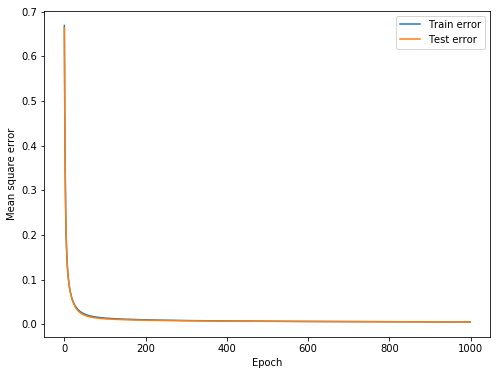

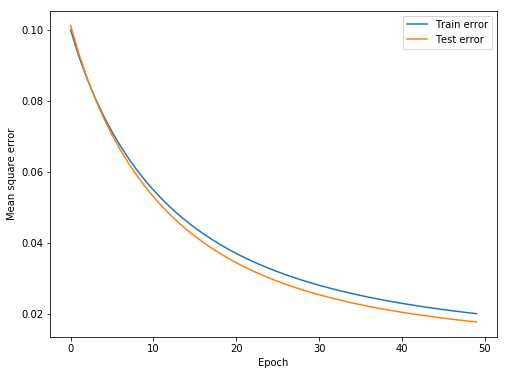

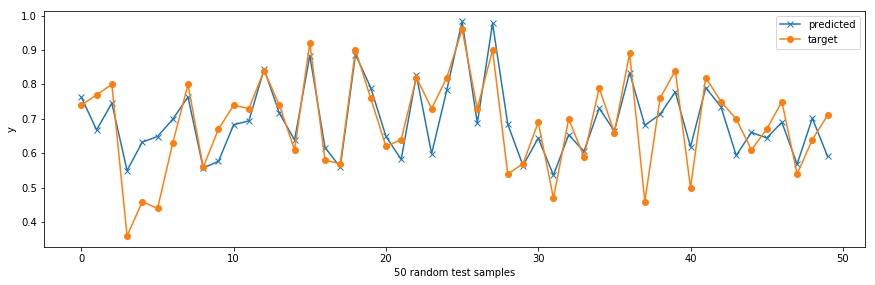

Training on 280 examples...
Epoch 0: train error 0.6687580943107605 test error 0.6635352373123169
Epoch 1000: train error 0.005368367303162813 test error 0.005512206349521875
Epoch 2000: train error 0.004188450053334236 test error 0.004751928616315126
Epoch 3000: train error 0.003849232103675604 test error 0.004428340122103691
Epoch 4000: train error 0.0037178099155426025 test error 0.004276558756828308
Epoch 5000: train error 0.0036651568952947855 test error 0.004183946177363396
Epoch 6000: train error 0.003624430624768138 test error 0.00415560370311141
Epoch 7000: train error 0.003585702972486615 test error 0.004156375303864479
Done.
Epoch with lowest test error: 6653 (0.004154592286795378)


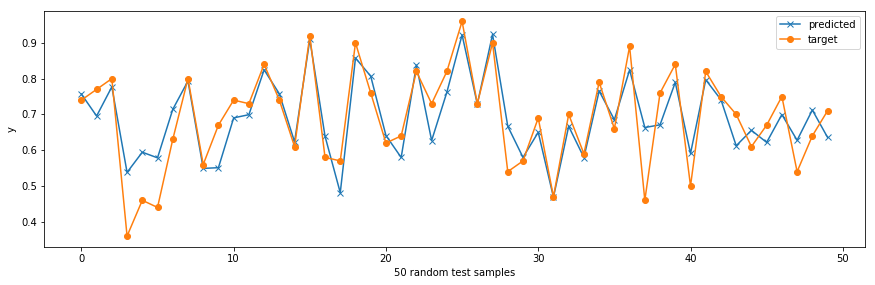

Training on 280 examples...
Epoch 0: train error 0.6687580943107605 test error 0.6635352373123169
Epoch 1000: train error 0.005368367303162813 test error 0.005512206349521875
Epoch 2000: train error 0.004188450053334236 test error 0.004751928616315126
Epoch 3000: train error 0.003849232103675604 test error 0.004428340122103691
Epoch 4000: train error 0.0037178099155426025 test error 0.004276558756828308
Epoch 5000: train error 0.0036651568952947855 test error 0.004183946177363396
Epoch 6000: train error 0.003624430624768138 test error 0.00415560370311141
Done.
Epoch with lowest test error: 6653 (0.004154592286795378)


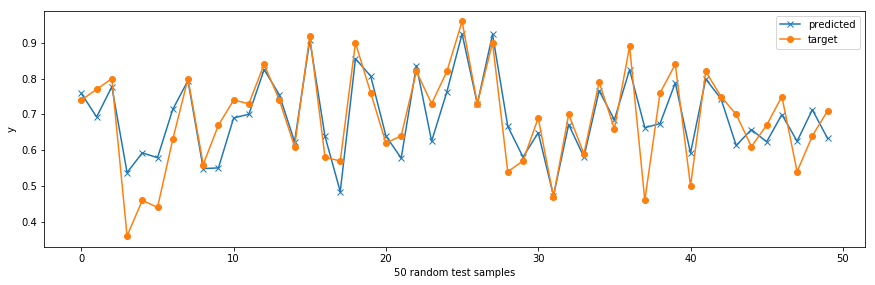

In [0]:
import numpy as np

NUM_FEATURES = 7

num_hidden = 1
num_neurons = 10

learning_rate = 0.001
reg_constant = 0.001
batch_size = 8

# Load training and testing data
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')

trainX = train_data[:, :-1]
trainY = train_data[:, -1]
testX = test_data[:, :-1]
testY = test_data[:, -1]

train_mean = np.mean(trainX, axis=0)
train_std = np.std(trainX, axis=0)

trainX = (trainX - train_mean) / train_std
trainY = trainY.reshape(trainY.shape[0], 1)
testX = (testX - train_mean) / train_std
testY = testY.reshape(testY.shape[0], 1)

test = testX[-50:]
target = testY[-50:]

# Question 1a
model = RegressionFFNN(NUM_FEATURES, num_hidden, num_neurons, reg_constant)
train_err, test_err = model.train(1000, learning_rate, batch_size, trainX, trainY, testX, testY)
plot_curves({"Train error": train_err, "Test error": test_err}, x_label=f"Epoch", y_label="Mean square error")
plot_curves({"Train error": train_err[10:60], "Test error": test_err[10:60]}, 
            x_label=f"Epoch", y_label="Mean square error")
predicted = model.test(test)
plot_comparisons("predicted", predicted, "target", target, x_label="50 random test samples", y_label="y")
model.sess.close()

# Question 1b, 1c
# Train for 8000 epochs and find the epoch with lowest test error
model = RegressionFFNN(NUM_FEATURES, num_hidden, num_neurons, reg_constant)
model.train(8000, learning_rate, batch_size, trainX, trainY, testX, testY, log_interval=1000)
predicted = model.test(test)
plot_comparisons("predicted", predicted, "target", target, x_label="50 random test samples", y_label="y")
model.sess.close()
# Train for the optimal number of epochs (6653) found previously
model = RegressionFFNN(NUM_FEATURES, num_hidden, num_neurons, reg_constant)
model.train(6653, learning_rate, batch_size, trainX, trainY, testX, testY, log_interval=1000)
predicted = model.test(test)
plot_comparisons("predicted", predicted, "target", target, x_label="50 random test samples", y_label="y")
model.sess.close()

### Question 2

                   GRE Score  TOEFL Score  University Rating       SOP       LOR      CGPA  Research  Chance of Admit
GRE Score           1.000000     0.832895           0.656091  0.567857  0.534071  0.818178  0.588473         0.782468
TOEFL Score         0.832895     1.000000           0.688428  0.627289  0.540354  0.822062  0.488900         0.785303
University Rating   0.656091     0.688428           1.000000  0.710292  0.644087  0.743667  0.468958         0.707464
SOP                 0.567857     0.627289           0.710292  1.000000  0.719201  0.704282  0.428632         0.643421
LOR                 0.534071     0.540354           0.644087  0.719201  1.000000  0.667819  0.429057         0.662317
CGPA                0.818178     0.822062           0.743667  0.704282  0.667819  1.000000  0.527933         0.856337
Research            0.588473     0.488900           0.468958  0.428632  0.429057  0.527933  1.000000         0.587964
Chance of Admit     0.782468     0.785303           0.70

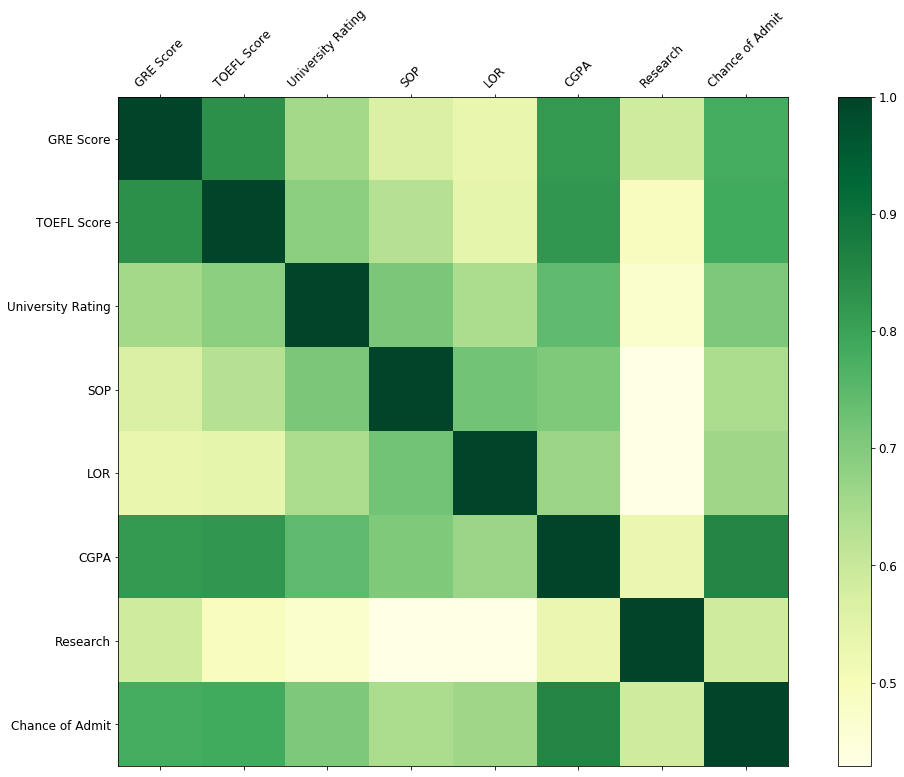

In [0]:
import numpy as np
import pandas as pd
import pylab as plt

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

columns = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research', 'Chance of Admit']
train_data = pd.DataFrame(data=np.load('train_data.npy'), columns=columns)

# compute correlation matrix
correlation_matrix = train_data.corr(method='pearson')
print(correlation_matrix)

# plot correlation matrix
fig = plt.figure(figsize=(18, 12))
plt.matshow(correlation_matrix, fignum=fig.number, cmap='YlGn')
plt.xticks(range(correlation_matrix.shape[1]), columns, fontsize=12, rotation=45)
plt.yticks(range(correlation_matrix.shape[1]), columns, fontsize=12)
cbr = plt.colorbar(cmap='YlGn')
cbr.ax.tick_params(labelsize=12)

### Question 3

Running recursive feature elimination (RFE)...
Training model(s) by removing 0 feature(s) from ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']...
The following features will be removed: []
Training on 280 examples...
Epoch 0: train error 0.6687580943107605 test error 0.6635352373123169
Epoch 500: train error 0.007016561925411224 test error 0.00683776568621397
Done.
Epoch with lowest test error: 1000 (0.005514172371476889)
Optimal features set: ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research'] (Removed: [], Min error: 0.005514172371476889)

Training model(s) by removing 1 feature(s) from ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']...
The following features will be removed: ['GRE Score']
Training on 280 examples...
Epoch 0: train error 0.5234193205833435 test error 0.4982790946960449
Epoch 500: train error 0.005961703602224588 test error 0.005636272951960564
Done.
Epoch with lowe

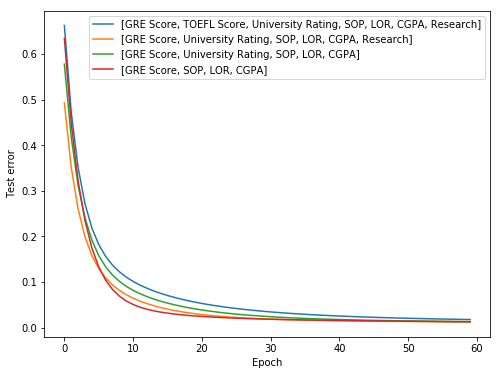

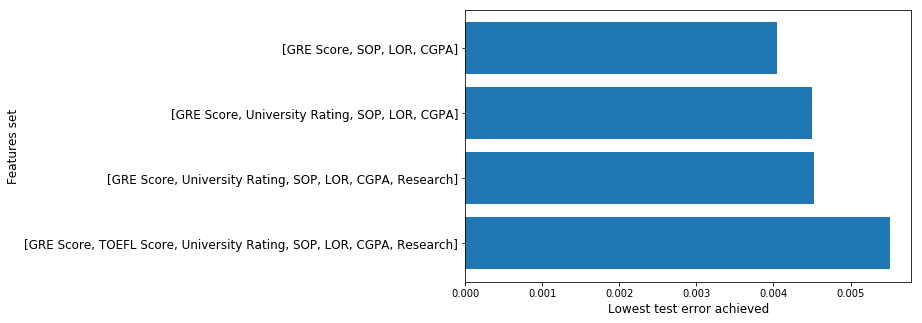

Training model(s) by removing 0 feature(s) from ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']...
The following features will be removed: []
Training on 280 examples...
Epoch 0: train error 0.6687580943107605 test error 0.6635352373123169
Epoch 500: train error 0.007016561925411224 test error 0.00683776568621397
Done.
Epoch with lowest test error: 1000 (0.005514172371476889)
Optimal features set: ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research'] (Removed: [], Min error: 0.005514172371476889)

Training model(s) by removing 1 feature(s) from ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR', 'CGPA', 'Research']...
The following features will be removed: ['GRE Score']
Training on 280 examples...
Epoch 0: train error 0.5234193205833435 test error 0.4982790946960449
Epoch 500: train error 0.005961703602224588 test error 0.005636272951960564
Done.
Epoch with lowest test error: 1000 (0.004920464940369129)
The 

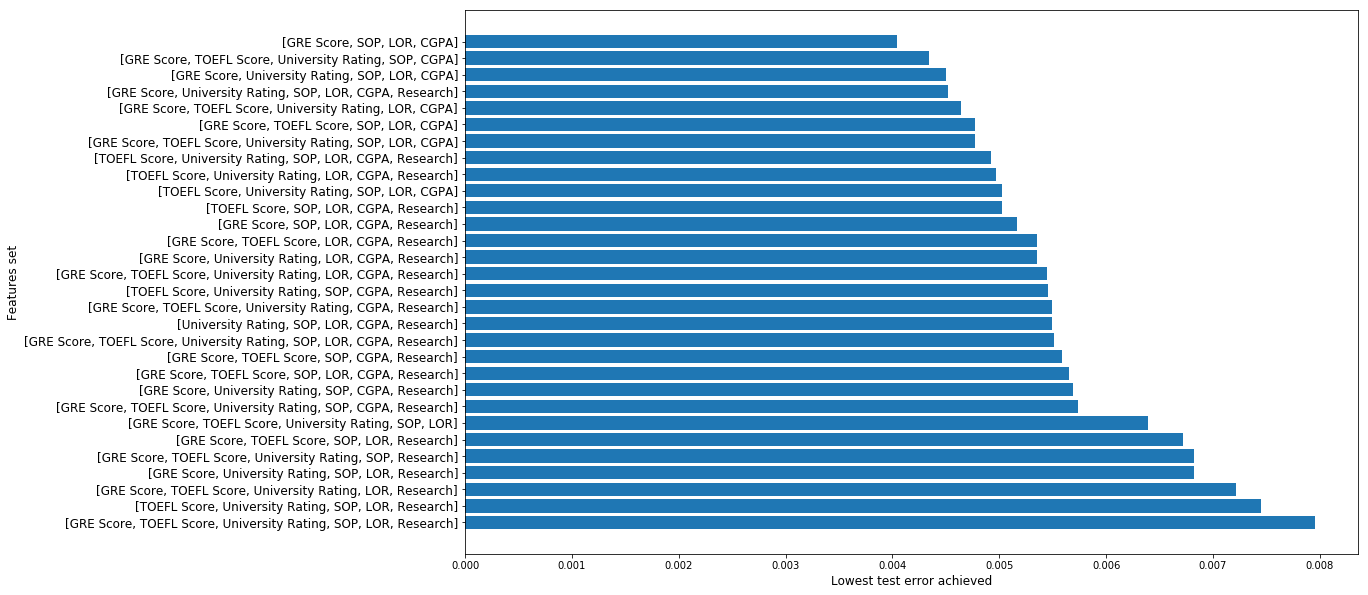

In [0]:
import itertools

import numpy as np

NUM_FEATURES = 7
COLUMNS = {'GRE Score': 0, 'TOEFL Score': 1, 'University Rating': 2, 'SOP': 3, 'LOR': 4, 'CGPA': 5, 'Research': 6}

num_hidden = 1
num_neurons = 10

learning_rate = 0.001
reg_constant = 0.001
epochs = 1000
batch_size = 8

# Load training and testing data
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')

trainX = train_data[:, :-1]
trainY = train_data[:, -1]
testX = test_data[:, :-1]
testY = test_data[:, -1]

train_mean = np.mean(trainX, axis=0)
train_std = np.std(trainX, axis=0)

trainX = (trainX - train_mean) / train_std
trainY = trainY.reshape(trainY.shape[0], 1)
testX = (testX - train_mean) / train_std
testY = testY.reshape(testY.shape[0], 1)

test_err_cache = dict()
def remove_n_features(n, columns):
    print(f"Training model(s) by removing {n} feature(s) from {columns}...")
    results = []
    for feats in itertools.combinations([COLUMNS[c] for c in columns], n):
        removed = [c for c, i in COLUMNS.items() if i in feats]
        print("The following features will be removed:", removed)
        remaining_indices = [COLUMNS[c] for c in columns if COLUMNS[c] not in feats]
        trainX_ = trainX[:, remaining_indices]
        testX_ = testX[:, remaining_indices]
        model = RegressionFFNN(len(columns) - n, num_hidden, num_neurons, reg_constant)
        _, test_err = model.train(epochs, learning_rate, batch_size, trainX_, trainY, testX_, testY, log_interval=500)
        
        remaining_columns = [c for c in columns if c not in removed]
        test_err_cache[str(remaining_columns)] = test_err
        results.append((remaining_columns, removed, min(test_err)))

        model.sess.close()
        print("=" * 110)

    sorted_results = sorted(results, key=lambda x: x[-1])
    optimal_features = sorted_results[0][0]
    removed_features = sorted_results[0][1]
    min_error = sorted_results[0][2]
    print(f"Optimal features set: {optimal_features} (Removed: {removed_features}, Min error: {min_error})\n")
    
    return sorted_results

def run_rfe():
    print("Running recursive feature elimination (RFE)...")
    features = [list(COLUMNS.keys())]
    test_err = [remove_n_features(0, features[-1])[0][-1]]
    while True:
        optimal, removed, min_error = remove_n_features(1, features[-1])[0]
        if min_error < test_err[-1]:
            print(f"The feature '{removed[0]}' will be removed'")
            features.append(optimal)
            test_err.append(min_error)
        else:
            break
    print(f"Optimal features set from RFE: {features[-1]}, mse loss: {test_err[-1]}\n")
    
    curves_to_plot = {str(cols).replace("'", ''): test_err_cache[str(cols)][:60] for cols in features}
    plot_curves(curves_to_plot, x_label=f"Epoch", y_label="Test error")
    feats = {str(features[i]).replace("'", ""):test_err[i] for i in range(len(features))}
    plot_bar_chart(feats, x_label="Lowest test error achieved", y_label="Features set", figsize=(8, 5))

    return features[-1], test_err[-1]

columns, min_loss = run_rfe()
seven_feats = remove_n_features(0, list(COLUMNS.keys()))
six_feats = remove_n_features(1, list(COLUMNS.keys()))
five_feats = remove_n_features(2, list(COLUMNS.keys()))

# plot graphs
feats = {str(columns).replace("'", ""): min_loss}
feats.update({str(c).replace("'", ""):e for c, _, e in seven_feats})
feats.update({str(c).replace("'", ""):e for c, _, e in six_feats})
feats.update({str(c).replace("'", ""):e for c, _, e in five_feats})
plot_bar_chart(feats, x_label="Lowest test error achieved", y_label="Features set", figsize=(16, 10))

### Question 4

Training on 280 examples...
Epoch 0: train error 0.6673344373703003 test error 0.6351518034934998
Epoch 100: train error 0.014180545695126057 test error 0.009738478809595108
Epoch 200: train error 0.010665259324014187 test error 0.006859971210360527
Epoch 300: train error 0.008983022533357143 test error 0.0057747866958379745
Epoch 400: train error 0.00798209011554718 test error 0.005219836253672838
Epoch 500: train error 0.007314728107303381 test error 0.00485875504091382
Epoch 600: train error 0.006811516359448433 test error 0.004600693937391043
Epoch 700: train error 0.006437075790017843 test error 0.00440535182133317
Epoch 800: train error 0.006147777661681175 test error 0.004256909247487783
Epoch 900: train error 0.005909332074224949 test error 0.0041389730758965015
Done.
Epoch with lowest test error: 1000 (0.004040959291160107)
Training on 280 examples...
Epoch 0: train error 0.1970611810684204 test error 0.19776830077171326
Epoch 100: train error 0.009004048071801662 test error 0

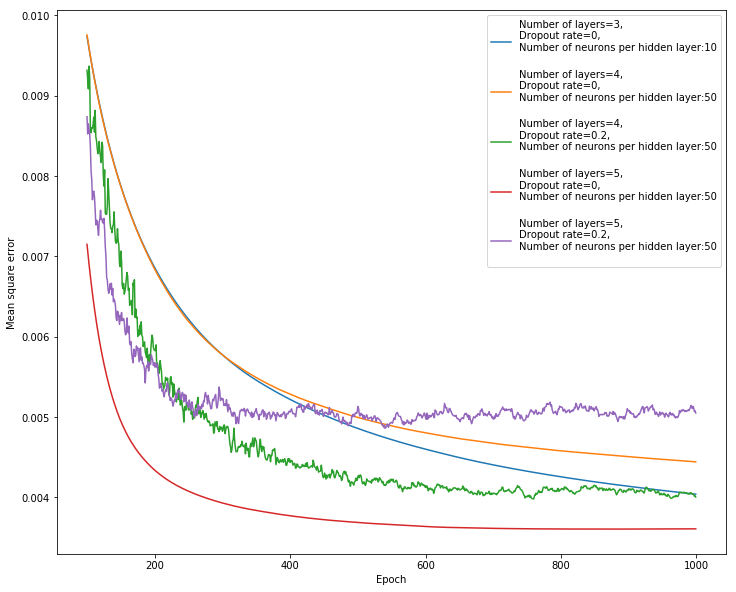

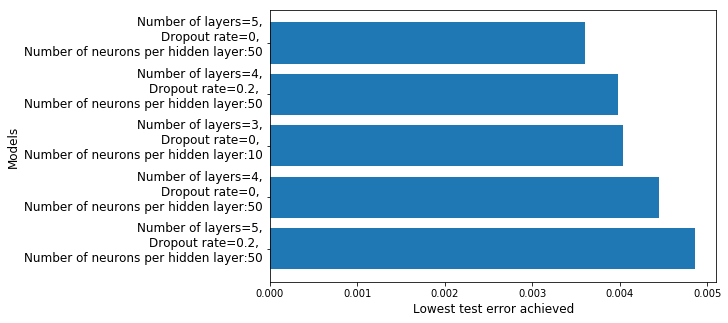

In [20]:
import numpy as np

NUM_FEATURES = 4

num_neurons = 50

learning_rate = 0.001
reg_constant = 0.001
epochs = 1000
batch_size = 8

# Load training and testing data
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')

trainX = train_data[:, [0, 3, 4, 5]]  # Select GRE Score, SOP, LOR and CGPA
trainY = train_data[:, -1]
testX = test_data[:, [0, 3, 4, 5]]  # Select GRE Score, SOP, LOR and CGPA
testY = test_data[:, -1]

train_mean = np.mean(trainX, axis=0)
train_std = np.std(trainX, axis=0)

trainX = (trainX - train_mean) / train_std
trainY = trainY.reshape(trainY.shape[0], 1)
testX = (testX - train_mean) / train_std
testY = testY.reshape(testY.shape[0], 1)

def run_experiment(num_hidden, dropout_rate):
    model = RegressionFFNN(NUM_FEATURES, num_hidden, num_neurons, reg_constant)
    _, test_err = model.train(epochs, learning_rate, batch_size, trainX, trainY, testX, testY, dropout_rate)
    model.sess.close()

    return test_err

# Original 3-layer network
model = RegressionFFNN(NUM_FEATURES, 1, 10, reg_constant)
_, test_err = model.train(epochs, learning_rate, batch_size, trainX, trainY, testX, testY)
results = {"Number of layers=3,\nDropout rate=0, \nNumber of neurons per hidden layer:10\n": test_err}
model.sess.close()

params = [(2, 0), (2, 0.2), (3, 0), (3, 0.2)]
for num_hidden, dropout_rate in params:
    layer = num_hidden + 2
    key = f"Number of layers={layer},\nDropout rate={dropout_rate}, \nNumber of neurons per hidden layer:{num_neurons}\n"
    results[key] = run_experiment(num_hidden, dropout_rate)

# plot graphs
plot_curves({k: v[100:] for k, v in results.items()}, x_label=f"Epoch", y_label="Mean square error", offset=100, figsize=(12, 10))
plot_bar_chart({k: min(v) for k, v in results.items()}, 
               x_label="Lowest test error achieved", y_label="Models", figsize=(8, 5))